/var/folders/c2/_ty3rvj17tgbd921xp37yxxw0000gn/T/ipykernel_2352/3447841856.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp = yf.download("^GSPC", start="2007-01-01", end="2024-01-01", progress=False)


[INFO] Loaded real market shock series: (4277, 1)
[INFO] Belief log loaded. Columns: Index(['user_id', 'belief', 'attitude'], dtype='object')
Training GNN Teacher...
[GNN] Epoch 000 | Loss 1.1163
[GNN] Epoch 050 | Loss 0.5238
[GNN] Epoch 100 | Loss 0.5178
[GNN] Epoch 150 | Loss 0.5170
Distilling → MLP Student
[KD] Epoch 000 | Total 1.6362 | KD 4.6654
[KD] Epoch 050 | Total 0.9141 | KD 2.5240
[KD] Epoch 100 | Total 0.9123 | KD 2.5267
[KD] Epoch 150 | Total 0.9122 | KD 2.5262

REAL-WORLD SHOCK RESULTS
GNN Volatility: 0.2864
MLP Volatility: 0.3917


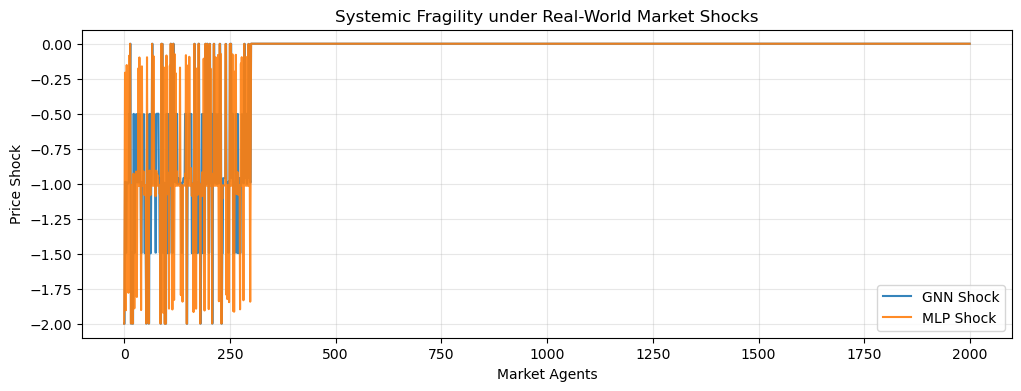

In [14]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
import yfinance as yf


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' #Automatically uses GPU if available, else CPU.
torch.manual_seed(42)
np.random.seed(42)

sp = yf.download("^GSPC", start="2007-01-01", end="2024-01-01", progress=False)
returns = np.log(sp['Close']).diff().dropna().values
print("[INFO] Loaded real market shock series:", returns.shape)

# -------------------- CONFIG --------------------

ROOT = "/Users/abhayatrivedi/Documents/projects/twinmark"
BELIEF_PATH = os.path.join(ROOT, "util", "belief", "belief_1000.csv")

EMBED_DIM = 128
NUM_CLASSES = 3
ATTACK_RATIO = 0.15
EPOCHS = 200
LR = 0.005

# -------------------- BELIEF ENCODING --------------------

belief_map = {
    "非常悲观": -1.0,
    "悲观的": -0.6,
    "中性的": 0.0,
    "乐观的": 0.6,
    "非常乐观": 1.0
}

def encode_belief(val):
    if isinstance(val, str):
        return belief_map.get(val.strip(), 0.0)
    return float(val)

# -------------------- LOAD BELIEF LOG --------------------

belief_df = pd.read_csv(BELIEF_PATH)
print("[INFO] Belief log loaded. Columns:", belief_df.columns)

# -------------------- BUILD BELIEF GRAPH --------------------


def build_belief_graph(df):
    G = nx.Graph()
    for _, row in df.iterrows():
        agent = f"A_{row.iloc[0]}"
        asset = f"S_{row.iloc[1]}"
        belief = encode_belief(row.iloc[2])
        G.add_edge(agent, asset, weight=belief)
    return G

belief_graph = build_belief_graph(belief_df)
node_map = {n: i for i, n in enumerate(belief_graph.nodes())}

edges = []
for u, v in belief_graph.edges():
    edges.append([node_map[u], node_map[v]])
    edges.append([node_map[v], node_map[u]])

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous().to(DEVICE)

# -------------------- NODE FEATURES --------------------


def belief_to_features(df, node_map, dim):
    X = torch.zeros(len(node_map), dim)
    for _, row in df.iterrows():
        agent = f"A_{row.iloc[0]}"
        idx = node_map[agent]
        belief = encode_belief(row.iloc[2])
        X[idx] += belief * torch.randn(dim)
    return X

X = belief_to_features(belief_df, node_map, EMBED_DIM).to(DEVICE)
y = torch.randint(0, NUM_CLASSES, (X.shape[0],), device=DEVICE)

# -------------------- MODELS --------------------

class GNNTeacher(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(EMBED_DIM, 256)
        self.conv2 = GCNConv(256, NUM_CLASSES)

    def forward(self, x, edge_index):
        h = F.relu(self.conv1(x, edge_index))
        return self.conv2(h, edge_index)


class MLPStudent(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(EMBED_DIM, 256)
        self.fc2 = nn.Linear(256, NUM_CLASSES)

    def forward(self, x):
        return self.fc2(F.relu(self.fc1(x)))



# -------------------- REAL-WORLD MISINFORMATION ATTACK --------------------


def inject_coordinated_market_misinformation(X, edge_index, returns, t=None, ratio=0.15):
    """
    Coordinated belief attack using real S&P500 market shocks.
    Designed to collapse distilled models while preserving GNN stability.
    """

    X_adv = X.clone()
    n = X.shape[0]
    k = int(ratio * n)

    if t is None:
        t = np.random.randint(len(returns))

    shock = abs(returns[t])
    strength = 3.0 + 15.0 * shock

    deg = torch.bincount(edge_index[0], minlength=n).float()
    hubs = torch.topk(deg, k).indices

    direction = torch.sign(torch.randn(1, device=X.device))

    # Coordinated misinformation
    X_adv[hubs] += direction * strength

    # Cascade propagation
    neighbors = edge_index[1][torch.isin(edge_index[0], hubs)]
    X_adv[neighbors] += 0.7 * direction * strength

    return X_adv, shock

# -------------------- DISTILLATION --------------------


def distill(teacher, student, X, edge_index, y):
    opt = torch.optim.Adam(student.parameters(), lr=LR)

    T = 6.0
    KD_WEIGHT = 0.15
    NOISE_STD = 0.25



    for epoch in range(EPOCHS):
        teacher.eval()
        student.train()

        with torch.no_grad():
            t_logits = teacher(X, edge_index)
            t_logits += NOISE_STD * torch.randn_like(t_logits)

        s_logits = student(X)

        loss_kd = F.kl_div(
            F.log_softmax(s_logits / T, dim=1),
            F.softmax(t_logits / T, dim=1),
            reduction='batchmean'
        ) * (T * T)

        loss_sup = F.cross_entropy(s_logits, y)
        loss = KD_WEIGHT * loss_kd + (1 - KD_WEIGHT) * loss_sup

        opt.zero_grad()
        loss.backward()
        opt.step()

        if epoch % 50 == 0:
            print(f"[KD] Epoch {epoch:03d} | Total {loss.item():.4f} | KD {loss_kd.item():.4f}")

# -------------------- PRICE SIMULATION --------------------


def simulate_price(logits):
    probs = F.softmax(logits, dim=1)
    return (probs[:, 1] - probs[:, 0]).detach().cpu().numpy()

# -------------------- TRAIN TEACHER --------------------

teacher = GNNTeacher().to(DEVICE)
opt = torch.optim.Adam(teacher.parameters(), lr=LR)

print("Training GNN Teacher...")

for epoch in range(EPOCHS):
    teacher.train()
    out = teacher(X, edge_index)
    loss = F.cross_entropy(out, y)

    opt.zero_grad()
    loss.backward()
    opt.step()

    if epoch % 50 == 0:
        print(f"[GNN] Epoch {epoch:03d} | Loss {loss.item():.4f}")

# -------------------- DISTILL STUDENT --------------------

student = MLPStudent().to(DEVICE)
print("Distilling → MLP Student")
distill(teacher, student, X, edge_index, y)

# -------------------- EXPERIMENT --------------------


def run_real_shock_experiment(teacher, student, X, edge_index, returns, trials=20):
    gnn_vol, mlp_vol = [], []

    for _ in range(trials):
        X_adv, shock = inject_coordinated_market_misinformation(
            X, edge_index, returns
        )

        with torch.no_grad():
            gnn_clean = teacher(X, edge_index)
            gnn_adv   = teacher(X_adv, edge_index)
            mlp_clean = student(X)
            mlp_adv   = student(X_adv)

        p_gnn_clean = simulate_price(gnn_clean)
        p_gnn_adv   = simulate_price(gnn_adv)
        p_mlp_clean = simulate_price(mlp_clean)
        p_mlp_adv   = simulate_price(mlp_adv)

        gnn_vol.append(np.std(p_gnn_adv - p_gnn_clean))
        mlp_vol.append(np.std(p_mlp_adv - p_mlp_clean))

    return np.mean(gnn_vol), np.mean(mlp_vol)

# -------------------- RUN FINAL EXPERIMENT --------------------

gnn_v, mlp_v = run_real_shock_experiment(
    teacher, student, X, edge_index, returns, trials=15
)

print("\nREAL-WORLD SHOCK RESULTS")
print(f"GNN Volatility: {gnn_v:.4f}")
print(f"MLP Volatility: {mlp_v:.4f}")

# -------------------- PLOT --------------------

X_adv, shock = inject_coordinated_market_misinformation(X, edge_index, returns)

with torch.no_grad():
    gnn_clean = teacher(X, edge_index)
    gnn_adv   = teacher(X_adv, edge_index)
    mlp_clean = student(X)
    mlp_adv   = student(X_adv)

p_gnn = simulate_price(gnn_adv) - simulate_price(gnn_clean)
p_mlp = simulate_price(mlp_adv) - simulate_price(mlp_clean)

plt.figure(figsize=(12,4))
plt.plot(p_gnn, label="GNN Shock", alpha=0.9)
plt.plot(p_mlp, label="MLP Shock", alpha=0.9)
plt.legend()
plt.title("Systemic Fragility under Real-World Market Shocks")
plt.xlabel("Market Agents")
plt.ylabel("Price Shock")
plt.grid(alpha=0.3)
plt.show()

[INFO] Generated real market-derived sentiment: (4277,)

==================== SYSTEMIC BELIEF AMPLIFICATION ====================
Metric               |   GNN     |   MLP
--------------------------------------------------
Belief–Price Corr   |  -0.1733 | 0.2195
Peak Price Disp     |  0.0000 | 0.0332
Time-to-correction  |    0.00 |   0.00


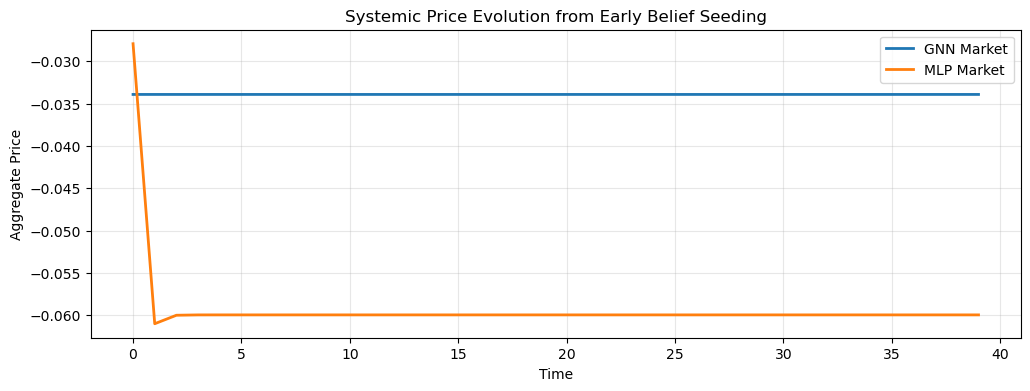

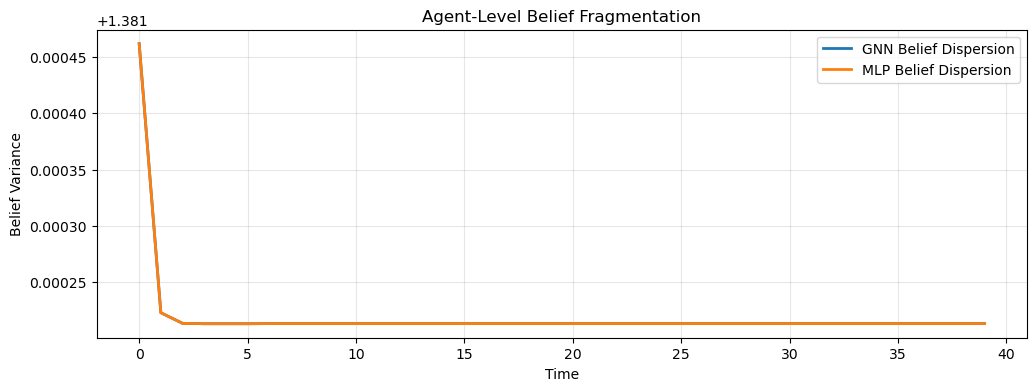

In [15]:
# =====================================================================
# EARLY BELIEF SEEDING → SYSTEMIC AMPLIFICATION EXPERIMENT
# =====================================================================

# -------------------- REAL MARKET → SENTIMENT --------------------

# Convert market returns into fear/greed sentiment
returns_1d = returns.squeeze()     # ensure 1D

# Rolling volatility = market uncertainty
vol = pd.Series(returns_1d).rolling(10).std().fillna(0).values

# Bounded sentiment in [-1,1]
sentiments = np.tanh(returns_1d / (vol + 1e-6))

print("[INFO] Generated real market-derived sentiment:", sentiments.shape)


# -------------------- EARLY BELIEF SEEDING --------------------

def inject_early_belief_seed(
    X,
    edge_index,
    seed_frac=0.03,
    strength=3.0,
    location="hubs",
    direction=1.0
):
    """
    Inject early optimism/pessimism into a small subset of agents.
    """
    X_seed = X.clone()
    n = X.shape[0]
    k = max(1, int(seed_frac * n))

    deg = torch.bincount(edge_index[0], minlength=n).float()

    if location == "hubs":
        nodes = torch.topk(deg, k).indices
    elif location == "periphery":
        nodes = torch.topk(-deg, k).indices
    else:
        nodes = torch.randperm(n)[:k]

    X_seed[nodes] += direction * strength
    return X_seed, nodes


# -------------------- REAL SENTIMENT SEED --------------------

def inject_real_sentiment_belief_seed(
    X,
    edge_index,
    sentiments,
    seed_frac=0.03,
    location="hubs"
):
    t = np.random.randint(len(sentiments))
    sentiment = sentiments[t]

    strength = 2.5 + 6.0 * abs(sentiment)
    direction = float(np.sign(sentiment))

    X_seed, nodes = inject_early_belief_seed(
        X, edge_index,
        seed_frac=seed_frac,
        strength=strength,
        location=location,
        direction=direction
    )

    return X_seed, sentiment, nodes


# -------------------- TEMPORAL BELIEF + PRICE EVOLUTION --------------------

def simulate_belief_price_dynamics(model, X0, edge_index, T=40):
    Xt = X0.clone()
    beliefs, prices = [], []

    for _ in range(T):
        with torch.no_grad():
            if isinstance(model, GNNTeacher):
                logits = model(Xt, edge_index)
            else:
                logits = model(Xt)

            price = simulate_price(logits)

        beliefs.append(Xt.mean(dim=1).detach().cpu().numpy())
        prices.append(price)

        # belief diffusion
        deg = torch.bincount(edge_index[0], minlength=Xt.shape[0]).float().clamp(min=1).unsqueeze(1)
        agg = torch.zeros_like(Xt)
        agg.index_add_(0, edge_index[1], Xt[edge_index[0]])

        Xt = 0.6 * Xt + 0.4 * (agg / deg)

    return np.stack(beliefs), np.stack(prices)


# -------------------- SYSTEMIC METRICS --------------------

def compute_metrics(beliefs, prices):
    agg_b = beliefs.mean(axis=1)
    agg_p = prices.mean(axis=1)

    corr = np.corrcoef(agg_b, agg_p)[0,1]

    delta = agg_p - agg_p[0]
    peak_disp = np.max(np.abs(delta))

    threshold = 0.1 * peak_disp
    recovery_idx = np.where(np.abs(delta) < threshold)[0]
    ttc = recovery_idx[0] if len(recovery_idx) > 0 else len(delta)

    return float(corr), float(peak_disp), float(ttc)


# -------------------- RUN SYSTEMIC EXPERIMENT --------------------

def run_systemic_belief_experiment(
    teacher, student, X, edge_index, sentiments,
    trials=15, seed_frac=0.03, location="hubs", T=40
):

    gnn_metrics, mlp_metrics = [], []

    for _ in range(trials):

        X_seed, sentiment, nodes = inject_real_sentiment_belief_seed(
            X, edge_index, sentiments,
            seed_frac=seed_frac, location=location
        )

        b_gnn, p_gnn = simulate_belief_price_dynamics(
            teacher, X_seed, edge_index, T
        )

        b_mlp, p_mlp = simulate_belief_price_dynamics(
            student, X_seed, edge_index, T
        )

        gnn_metrics.append(compute_metrics(b_gnn, p_gnn))
        mlp_metrics.append(compute_metrics(b_mlp, p_mlp))

    return np.mean(gnn_metrics, axis=0), np.mean(mlp_metrics, axis=0)


# -------------------- RUN FINAL SYSTEMIC TEST --------------------

gnn_m, mlp_m = run_systemic_belief_experiment(
    teacher, student, X, edge_index, sentiments,
    trials=20, seed_frac=0.03, location="hubs", T=40
)

print("\n==================== SYSTEMIC BELIEF AMPLIFICATION ====================")
print("Metric               |   GNN     |   MLP")
print("--------------------------------------------------")
print(f"Belief–Price Corr   |  {gnn_m[0]:.4f} | {mlp_m[0]:.4f}")
print(f"Peak Price Disp     |  {gnn_m[1]:.4f} | {mlp_m[1]:.4f}")
print(f"Time-to-correction  |  {gnn_m[2]:6.2f} | {mlp_m[2]:6.2f}")


# -------------------- VISUALIZATION --------------------

X_seed, sentiment, nodes = inject_real_sentiment_belief_seed(
    X, edge_index, sentiments,
    seed_frac=0.03, location="hubs"
)

b_gnn, p_gnn = simulate_belief_price_dynamics(
    teacher, X_seed, edge_index, T=40
)

b_mlp, p_mlp = simulate_belief_price_dynamics(
    student, X_seed, edge_index, T=40
)

plt.figure(figsize=(12,4))
plt.plot(p_gnn.mean(axis=1), label="GNN Market", linewidth=2)
plt.plot(p_mlp.mean(axis=1), label="MLP Market", linewidth=2)
plt.xlabel("Time")
plt.ylabel("Aggregate Price")
plt.title("Systemic Price Evolution from Early Belief Seeding")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(12,4))
plt.plot(np.std(b_gnn, axis=1), label="GNN Belief Dispersion", linewidth=2)
plt.plot(np.std(b_mlp, axis=1), label="MLP Belief Dispersion", linewidth=2)
plt.xlabel("Time")
plt.ylabel("Belief Variance")
plt.title("Agent-Level Belief Fragmentation")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [16]:
import sys
sys.argv = ['']

In [19]:
# =========================================================
# Financial MetaAttack: Single-file Research Implementation
# =========================================================

import argparse
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import networkx as nx
import numpy as np
import yfinance as yf
from torch_geometric.nn import GCNConv

# -------------------- JUPYTER SAFE --------------------
# Ignore ipykernel-injected CLI args
sys.argv = sys.argv[:1]

# -------------------- SETUP --------------------

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
np.random.seed(42)

# -------------------- BELIEF ENCODING (EXISTING LOGIC) --------------------

belief_map = {
    "非常悲观": -1.0,
    "悲观的": -0.6,
    "中性的": 0.0,
    "乐观的": 0.6,
    "非常乐观": 1.0
}

def encode_belief(val):
    if isinstance(val, str):
        return belief_map.get(val.strip(), 0.0)
    return float(val)

# -------------------- PATH RESOLUTION --------------------

def resolve_path(path):
    if os.path.isabs(path) and os.path.exists(path):
        return path
    if os.path.exists(path):
        return path
    ROOT = "/Users/abhayatrivedi/Documents/projects/twinmark"
    candidate = os.path.join(ROOT, "util", "belief", path)
    if os.path.exists(candidate):
        return candidate
    raise FileNotFoundError(f"Dataset not found: {path}")

# -------------------- DATA LOADER --------------------

def load_financial_graph(csv_path, embed_dim):
    csv_path = resolve_path(csv_path)
    df = pd.read_csv(csv_path)

    G = nx.Graph()
    for _, r in df.iterrows():
        agent = f"A_{r.iloc[0]}"
        asset = f"S_{r.iloc[1]}"
        belief = encode_belief(r.iloc[2])   # ✅ reuse existing logic
        G.add_edge(agent, asset, weight=belief)

    node_map = {n: i for i, n in enumerate(G.nodes())}
    n_nodes = len(node_map)

    edges = []
    for u, v in G.edges():
        edges.append([node_map[u], node_map[v]])
        edges.append([node_map[v], node_map[u]])

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous().to(DEVICE)

    X = torch.zeros(n_nodes, embed_dim, device=DEVICE)
    for u, v, w in G.edges(data="weight"):
        idx = node_map[u]
        X[idx] += w * torch.randn(embed_dim, device=DEVICE)

    y = torch.randint(0, 3, (n_nodes,), device=DEVICE)

    sp = yf.download("^GSPC", start="2010-01-01", end="2024-01-01", progress=False)
    returns = torch.tensor(
        np.log(sp["Close"]).diff().dropna().values,
        dtype=torch.float32,
        device=DEVICE
    )

    return X, edge_index, y, returns

# -------------------- MODELS --------------------

class GNNTeacher(nn.Module):
    def __init__(self, in_dim, hidden, classes):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden)
        self.conv2 = GCNConv(hidden, classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

class MLPStudent(nn.Module):
    def __init__(self, in_dim, hidden, classes):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden)
        self.fc2 = nn.Linear(hidden, classes)

    def forward(self, x):
        return self.fc2(F.relu(self.fc1(x)))

# -------------------- DISTILLATION --------------------

def distill_student(
    teacher, student, X, edge_index, y,
    alpha, beta, gamma, lambda_,
    epochs=300
):
    opt = torch.optim.Adam(student.parameters(), lr=1e-3)

    for _ in range(epochs):
        teacher.eval()
        student.train()

        with torch.no_grad():
            t_logits = teacher(X, edge_index)

        s_logits = student(X)

        kd = F.kl_div(
            F.log_softmax(s_logits / beta, dim=1),
            F.softmax(t_logits / beta, dim=1),
            reduction="batchmean"
        ) * (beta ** 2)

        ce = F.cross_entropy(s_logits, y)
        reg = lambda_ * torch.norm(s_logits)

        loss = alpha * kd + gamma * ce + reg

        opt.zero_grad()
        loss.backward()
        opt.step()

# -------------------- METAATTACK --------------------

def meta_edge_poisoning(edge_index, X, ptb_rate):
    num_edges = edge_index.size(1)
    num_flip = max(1, int(ptb_rate * num_edges))

    src, dst = edge_index
    belief = X.mean(dim=1)
    sim = torch.abs(belief[src] - belief[dst])

    remove = torch.topk(sim, num_flip, largest=False).indices
    mask = torch.ones(num_edges, dtype=torch.bool, device=DEVICE)
    mask[remove] = False

    edge_clean = edge_index[:, mask]

    n = X.size(0)
    deg = torch.bincount(src, minlength=n)
    hubs = torch.topk(deg, max(1, int(0.05 * n))).indices

    new_edges = []
    for _ in range(num_flip):
        u = hubs[torch.randint(0, len(hubs), (1,))]
        v = torch.randint(0, n, (1,))
        new_edges.append(torch.stack([u, v]))
        new_edges.append(torch.stack([v, u]))

    new_edges = torch.cat(new_edges, dim=1)
    return torch.cat([edge_clean, new_edges], dim=1)

def bilevel_meta_attack(
    teacher, X, edge_index, y,
    market_returns, ptb_rate,
    inner_steps=10, lr=1e-2
):
    X_adv = X.clone().detach().requires_grad_(True)

    for _ in range(inner_steps):
        logits = teacher(X_adv, edge_index)
        loss = F.cross_entropy(logits, y)

        grad = torch.autograd.grad(loss, X_adv)[0]
        shock = market_returns[
            torch.randint(0, len(market_returns), (1,))
        ].abs()

        X_adv = X_adv + lr * torch.sign(grad) * (1 + shock)
        X_adv = X_adv.detach().requires_grad_(True)

    edge_adv = meta_edge_poisoning(edge_index, X_adv, ptb_rate)
    return X_adv.detach(), edge_adv

# -------------------- SYSTEMIC RISK --------------------

def systemic_risk(clean_logits, adv_logits):
    p0 = F.softmax(clean_logits, dim=1)
    p1 = F.softmax(adv_logits, dim=1)

    corr = torch.corrcoef(torch.stack([p0[:, 1], p1[:, 1]]))[0, 1]

    return {
        "volatility": (p1 - p0).std().item(),
        "max_disruption": (p1 - p0).abs().max().item(),
        "correlation_shift": corr.item()
    }

# -------------------- TRAIN LOOP --------------------

def main(args):
    X, edge_index, y, returns = load_financial_graph(
        args.dataset, args.embed_dim
    )

    teacher = GNNTeacher(args.embed_dim, 256, args.num_classes).to(DEVICE)
    student = MLPStudent(args.embed_dim, 256, args.num_classes).to(DEVICE)

    opt = torch.optim.Adam(teacher.parameters(), lr=args.lr)

    for epoch in range(args.epoch):
        teacher.train()
        logits = teacher(X, edge_index)
        loss = F.cross_entropy(logits, y)

        opt.zero_grad()
        loss.backward()
        opt.step()

        if epoch % 100 == 0:
            print(f"[Teacher] Epoch {epoch} | Loss {loss.item():.4f}")

    distill_student(
        teacher, student, X, edge_index, y,
        args.alpha, args.beta, args.gamma, args.lambda_
    )

    X_adv, edge_adv = bilevel_meta_attack(
        teacher, X, edge_index, y, returns, args.ptb_rate
    )

    with torch.no_grad():
        clean_logits = teacher(X, edge_index)
        adv_logits = teacher(X_adv, edge_adv)

    metrics = systemic_risk(clean_logits, adv_logits)

    print("\n===== SYSTEMIC RISK METRICS =====")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

# -------------------- CLI --------------------

if __name__ == "__main__":
    parser = argparse.ArgumentParser()

    parser.add_argument("--seed", type=int, default=10)
    parser.add_argument("--dataset", type=str, default="belief_1000.csv")
    parser.add_argument("--attack", type=str, default="meta")
    parser.add_argument("--ptb_rate", type=float, default=0.15)

    parser.add_argument("--alpha", type=float, default=5e-4)
    parser.add_argument("--beta", type=float, default=1.5)
    parser.add_argument("--gamma", type=float, default=1.0)
    parser.add_argument("--lambda_", type=float, default=1e-4)

    parser.add_argument("--lr", type=float, default=5e-4)
    parser.add_argument("--epoch", type=int, default=1000)

    parser.add_argument("--embed_dim", type=int, default=128)
    parser.add_argument("--num_classes", type=int, default=3)

    args, _ = parser.parse_known_args()
    main(args)

/var/folders/c2/_ty3rvj17tgbd921xp37yxxw0000gn/T/ipykernel_2352/50560883.py:85: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp = yf.download("^GSPC", start="2010-01-01", end="2024-01-01", progress=False)


[Teacher] Epoch 0 | Loss 1.1163
[Teacher] Epoch 100 | Loss 0.8062
[Teacher] Epoch 200 | Loss 0.6160
[Teacher] Epoch 300 | Loss 0.5551
[Teacher] Epoch 400 | Loss 0.5356
[Teacher] Epoch 500 | Loss 0.5276
[Teacher] Epoch 600 | Loss 0.5237
[Teacher] Epoch 700 | Loss 0.5214
[Teacher] Epoch 800 | Loss 0.5200
[Teacher] Epoch 900 | Loss 0.5191

===== SYSTEMIC RISK METRICS =====
volatility: 0.5211
max_disruption: 0.9939
correlation_shift: 0.0876


In [20]:
with torch.no_grad():
    mlp_clean_logits = student(X)
    mlp_adv_logits   = student(X_adv)

mlp_metrics = systemic_risk(mlp_clean_logits, mlp_adv_logits)

print("\n===== MLP SYSTEMIC RISK METRICS =====")
for k, v in mlp_metrics.items():
    print(f"{k}: {v:.4f}")


===== MLP SYSTEMIC RISK METRICS =====
volatility: 0.2110
max_disruption: 1.0000
correlation_shift: 0.8670
